569
id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unna

<Axes: >

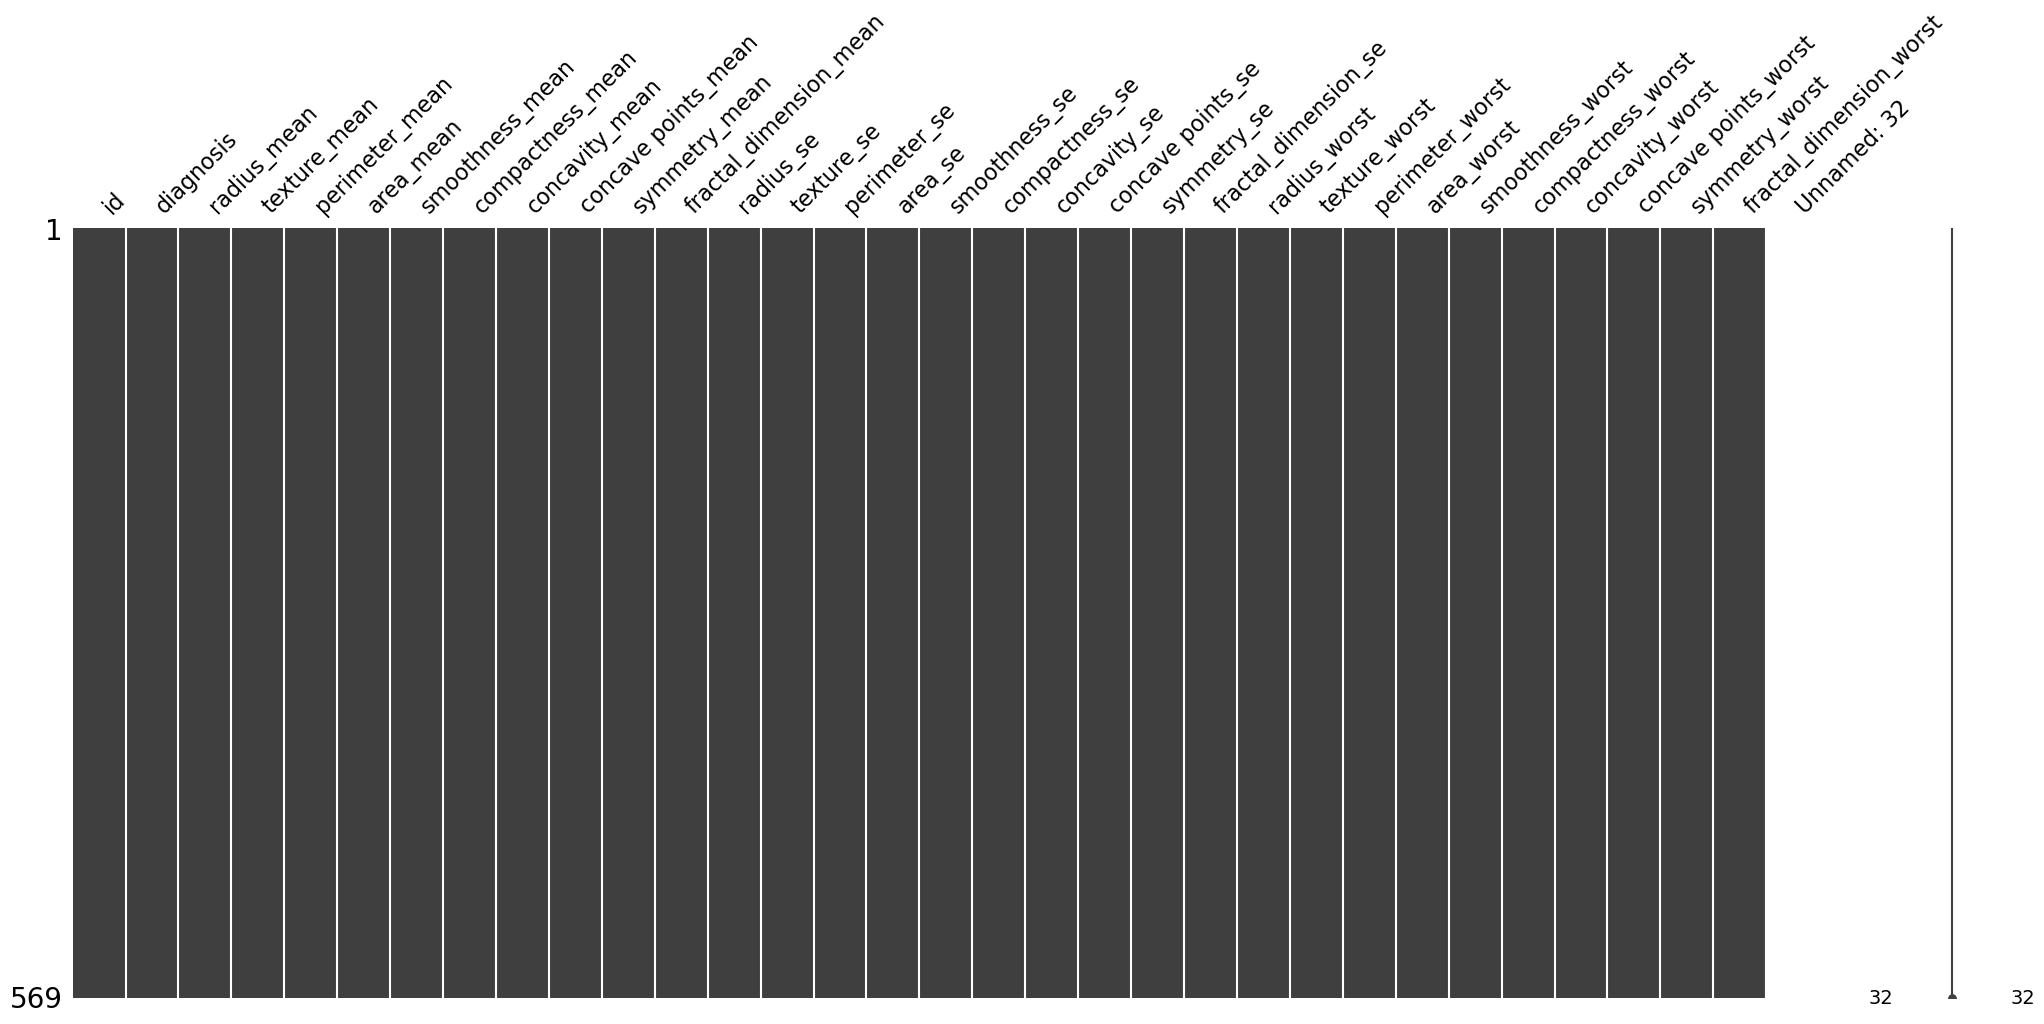

In [1]:
#Missingness = none


import pandas as pd

df = pd.read_csv("C:/Users/brad_/MSU/Year 1/STT810/Project/data.csv")


# Total missing values
print(df.isna().sum().sum())

# Missing values per column
print(df.isna().sum())

# Percentage missing per column
print(df.isna().mean() * 100)

# Missingness per row
print(df.isna().sum(axis=1))

# Visualize missingness
import missingno as msno
msno.matrix(df)

In [2]:
#target imbalance
df['diagnosis'].value_counts(normalize=True) * 100

diagnosis
B    62.741652
M    37.258348
Name: proportion, dtype: float64

In [21]:
#rebalance dataset
#initialize x and y
# Drop the target column to create X
X = df.drop('diagnosis', axis=1)

# Extract the target column as y
y = df['diagnosis']


###########
#Resampling
###########

#Random undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X, y)

df1 = pd.concat([pd.DataFrame(X_res, columns=X.columns),
                 pd.Series(y_res, name='diagnosis')], axis=1)


#Radnom oversampling
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_res2, y_res2 = ros.fit_resample(X, y)

df2 = pd.concat([pd.DataFrame(X_res2, columns=X.columns),
                 pd.Series(y_res2, name='diagnosis')], axis=1)


#----------------------------------------------------

############################
#Synthetic Sample Generation
############################

#SMOTE (help from gemini)
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np
import warnings
import sys

# Suppress warnings
try:
    from pandas.core.common import SettingWithCopyWarning
except ImportError:
    from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings('ignore', category=SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. Load Data ---
try:
    df = pd.read_csv('data.csv')
except FileNotFoundError:
    sys.exit("Error: 'data.csv' not found. Please ensure the file is present.")

# --- 2. Preprocessing ---
df = df.drop(columns=['id'], errors='ignore')

le = LabelEncoder()
if 'diagnosis' in df.columns:
    if df['diagnosis'].dtype == 'object':
        df['diagnosis'] = le.fit_transform(df['diagnosis'])
    elif df['diagnosis'].dtype not in (np.int64, np.float64) or df['diagnosis'].nunique() != 2:
        sys.exit("Error: 'diagnosis' column is not binary numeric.")
else:
    sys.exit("Error: 'diagnosis' column not found.")

# --- 3. Split Features and Target ---
Xsmote = df.drop('diagnosis', axis=1)
ysmote = df['diagnosis']

# --- 4. Handle Missing Values ---
Xsmote = Xsmote.dropna(axis=1, how='all')
Xsmote = Xsmote.fillna(Xsmote.mean())

# --- 5. Apply SMOTE ---
try:
    X_res3, y_res3 = SMOTE(random_state=42).fit_resample(Xsmote, ysmote)
except ValueError as e:
    sys.exit(f"SMOTE failed: {e}")

# --- 6. Combine SMOTE results ---
if X_res3 is None or y_res3 is None:
    sys.exit("Error: SMOTE results are missing. Cannot create df3.")

df3 = pd.concat([pd.DataFrame(X_res3, columns=Xsmote.columns),
                 pd.Series(y_res3, name='diagnosis')], axis=1)


#ADASY
#
X_res4, y_res4 = ADASYN().fit_resample(Xsmote, ysmote)
df4 = pd.concat([pd.DataFrame(X_res4, columns=Xsmote.columns),
                 pd.Series(y_res4, name='diagnosis')], axis=1)


#---------------------------------------------------------------
# ##########################
# #Hybrid (help from gemini)
# ##########################

# #Combination over and undersampling
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN # Using the hybrid method
import numpy as np
import warnings
import sys

# --- Warning Suppression (for cleaner output) ---
try:
    from pandas.core.common import SettingWithCopyWarning
except ImportError:
    from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings('ignore', category=SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 1. Load Data ---
try:
    df = pd.read_csv('data.csv')
except FileNotFoundError:
    print("Error: 'data.csv' not found.")
    sys.exit(1)

# --- 2. Preprocessing & Encoding ---

# Remove ID column
df = df.drop(columns=['id'], errors='ignore')

# Convert diagnosis (M/B) to numeric (M=1, B=0) if necessary
le = LabelEncoder()
if 'diagnosis' in df.columns:
    if df['diagnosis'].dtype == 'object':
        df['diagnosis'] = le.fit_transform(df['diagnosis'])
    # Added protection for already numeric data
    elif df['diagnosis'].dtype in (np.int64, np.float64) and df['diagnosis'].nunique() == 2:
        pass
else:
    print("Error: 'diagnosis' column not found.")
    sys.exit(1)


# --- 3. Split Features (X) and Target (y) ---
# We are using X and y names as per your SMOTEENN snippet
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# --- 4. Handle Missing Values (Imputation) ---
# This is the CRITICAL STEP to prevent the ValueError: Input X contains NaN

# Step 4a: Drop columns that are entirely NaN (100% missing)
X = X.dropna(axis=1, how='all')

# Step 4b: Impute remaining partial NaNs with the mean of the respective column
if X.isna().sum().sum() > 0:
    X = X.fillna(X.mean())


# Initialize results to prevent NameError
X_res5 = None
y_res5 = None

# --- 5. Apply SMOTEENN (Hybrid Resampling) ---
try:
    # Variables X_res5 and y_res5 are defined here on success
    X_res5, y_res5 = SMOTEENN(random_state=42).fit_resample(X, y)
except ValueError as e:
    print(f"\n--- FATAL ERROR ---")
    print(f"SMOTEENN failed. The error was: {e}")
    sys.exit(1)


# --- 6. Combine Data into new DataFrame 'df5' ---

if X_res5 is None or y_res5 is None:
    print("\nError: SMOTEENN results (X_res5, y_res5) are missing. Cannot create df5.")
    sys.exit(1)

# Combine the resampled features (X_res5) and target (y_res5)
# Ensure we use the columns from the cleaned feature set X
df5 = pd.concat([pd.DataFrame(X_res5, columns=X.columns),
                 pd.Series(y_res5, name='diagnosis')], axis=1)


In [22]:
#comparing the resampled datasets
print(df['diagnosis'].value_counts(normalize=True) * 100)
print(len(df['diagnosis']))
print(df1['diagnosis'].value_counts(normalize=True) * 100)
print(len(df1['diagnosis']))
print(df2['diagnosis'].value_counts(normalize=True) * 100)
print(len(df2['diagnosis']))
print(df3['diagnosis'].value_counts(normalize=True) * 100)
print(len(df3['diagnosis']))
print(df4['diagnosis'].value_counts(normalize=True) * 100)
print(len(df4['diagnosis']))
print(df5['diagnosis'].value_counts(normalize=True) * 100)
print(len(df5['diagnosis']))



diagnosis
0    62.741652
1    37.258348
Name: proportion, dtype: float64
569
diagnosis
0    50.0
1    50.0
Name: proportion, dtype: float64
424
diagnosis
1    50.0
0    50.0
Name: proportion, dtype: float64
714
diagnosis
1    50.0
0    50.0
Name: proportion, dtype: float64
714
diagnosis
1    50.06993
0    49.93007
Name: proportion, dtype: float64
715
diagnosis
0    50.563607
1    49.436393
Name: proportion, dtype: float64
621
